# Gene Ontology generic slim

In [1]:
from ontobio.ontol_factory import OntologyFactory
ont = OntologyFactory().create("go")
slim = OntologyFactory().create("goslim_generic.json")

MOLECULAR_FUNCTION = "GO:0003674"

slim_go_terms = [el for el in list(slim.get_graph().nodes()) if el.startswith("GO")] # get all GO terms in generic slim set
molecular_functions = ont.descendants(MOLECULAR_FUNCTION) # get all molecular functions in GO
slim_molecular_functions = list(set(slim_go_terms) & set(molecular_functions)) # take intersetcion between molecular functions and slim GO terms
slim_molecular_functions_descendants = {el : set(ont.descendants(el)) for el in slim_molecular_functions} # get all descendants of the above

In [2]:
import pandas as pd
import torch
import numpy as np

# this is a customized version of the UniProt database, only for human proteins, which are around 20k
# the columns were chosen to minimize the size of the file while maintaining useful information
df = pd.read_csv("uniprotkb_reviewed_true_AND_model_organ_2023_12_29.tsv", sep="\t")
df = df[~df['Gene Ontology (GO)'].isna()] # remove the ones without GO annotations

In [3]:
df = df[~df['Gene Ontology (molecular function)'].isna()] # remove the ones without GO annotations
df.head()

,Entry,Entry Name,Protein names,Gene Names,Organism,Length,Sequence,Gene Ontology (molecular function),Gene Ontology (cellular component),Gene Ontology (biological process),Gene Ontology IDs,Gene Ontology (GO)
1,A0A024RBG1,NUD4B_HUMAN,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,Homo sapiens (Human),181,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,bis(5'-adenosyl)-hexaphosphatase activity [GO:...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,adenosine 5'-(hexahydrogen pentaphosphate) cat...,GO:0000298; GO:0003723; GO:0005634; GO:0005737...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...
28,A0A075B6Q5,HV364_HUMAN,Immunoglobulin heavy variable 3-64,IGHV3-64,Homo sapiens (Human),118,MMEFGLSWVFLVAIFKGVQCEVQLVESGEGLVQPGGSLRLSCAASG...,antigen binding [GO:0003823],extracellular region [GO:0005576]; immunoglobu...,immunoglobulin mediated immune response [GO:00...,GO:0003823; GO:0005576; GO:0005886; GO:0016064...,extracellular region [GO:0005576]; immunoglobu...
30,A0A075B6R2,HV404_HUMAN,Immunoglobulin heavy variable 4-4,IGHV4-4,Homo sapiens (Human),117,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,antigen binding [GO:0003823],extracellular region [GO:0005576]; immunoglobu...,immunoglobulin mediated immune response [GO:00...,GO:0003823; GO:0005576; GO:0005886; GO:0016064...,extracellular region [GO:0005576]; immunoglobu...
38,A0A075B6T6,TVAL2_HUMAN,T cell receptor alpha variable 12-2,TRAV12-2,Homo sapiens (Human),113,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,peptide antigen binding [GO:0042605],T cell receptor complex [GO:0042101],adaptive immune response [GO:0002250],GO:0002250; GO:0042101; GO:0042605,T cell receptor complex [GO:0042101]; peptide ...
43,A0A075B6W5,TVA23_HUMAN,T cell receptor alpha variable 23/delta variab...,TRAV23DV6,Homo sapiens (Human),121,MDKILGASFLVLWLQLCWVSGQQKEKSDQQQVKQSPQSLIVQKGGI...,peptide antigen binding [GO:0042605],T cell receptor complex [GO:0042101],adaptive immune response [GO:0002250],GO:0002250; GO:0042101; GO:0042605,T cell receptor complex [GO:0042101]; peptide ...


<AxesSubplot:>

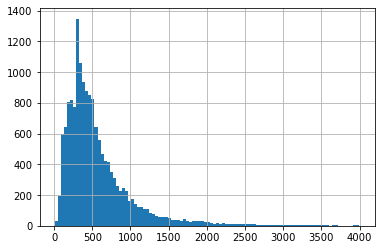

In [4]:
df[df['Length'] < 4000]['Length'].hist(bins=100)

In [5]:
df['Gene Ontology (molecular function)'] = df['Gene Ontology (molecular function)']\
    .apply(lambda x: x.split(";")).apply(lambda x: [el[el.index("[GO")+1:-1] for el in x])

In [6]:
for k in slim_molecular_functions:
    df[ont.node(k)['label']] = df['Gene Ontology (molecular function)']\
        .apply(lambda x: max([True if el in slim_molecular_functions_descendants[k] else False for el in x]))

In [7]:
ohe_df = df.drop(columns=['Entry', 'Entry Name', 'Protein names', 'Gene Names', 'Organism',
                            'Length', 'Gene Ontology (molecular function)',
                            'Gene Ontology (cellular component)',
                            'Gene Ontology (biological process)', 'Gene Ontology IDs',
                            'Gene Ontology (GO)'])
ohe_df.head()

,Sequence,RNA binding,antioxidant activity,histone binding,lipid binding,toxin activity,molecular sequestering activity,cytoskeletal motor activity,molecular function regulator activity,"catalytic activity, acting on RNA",...,nutrient reservoir activity,GTPase activity,"catalytic activity, acting on DNA",cell adhesion mediator activity,"catalytic activity, acting on a protein",lyase activity,cyclase activity,catalytic activity,hydrolase activity,virus coreceptor activity
1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
28,MMEFGLSWVFLVAIFKGVQCEVQLVESGEGLVQPGGSLRLSCAASG...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43,MDKILGASFLVLWLQLCWVSGQQKEKSDQQQVKQSPQSLIVQKGGI...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
labels = ohe_df.drop(columns=["Sequence"]).columns
X = df[labels].to_numpy().astype(np.float32)
l = []
for i in range(X.shape[0]):
    l.append(torch.tensor(X[i,:]))

# LLM Fine Tuning (using a Logistic Regression as Classification Head)
This way we take advantage of Logistic Regression multivariate response and perform independent classification of all the various classes

In [9]:
from datasets import Dataset

ds = Dataset.from_dict({"labels": l, "sequence" : df['Sequence']})
ds = ds.shuffle(seed=42).train_test_split(test_size=0.2)
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 3205
    })
})

In [10]:
from transformers import AutoTokenizer, EsmModel
import torch
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true"

#checkpoint = "facebook/esm2_t30_150M_UR50D"
#checkpoint = "facebook/esm2_t12_35M_UR50D"
checkpoint = "facebook/esm2_t6_8M_UR50D"

BATCH_SIZE = 4
NUM_EPOCHS = 6

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = EsmModel.from_pretrained(checkpoint)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def preprocess_tokenize(mapped_ds):
    return tokenizer(mapped_ds['sequence'], truncation=True, max_length=1024)

ds = ds.map(preprocess_tokenize)
ds = ds.remove_columns("sequence")
ds

Map:   0%|          | 0/12817 [00:00<?, ? examples/s]

Map:   0%|          | 0/3205 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3205
    })
})

In [12]:
#import pytorch_lightning as pl
import torch.nn as nn
from transformers import Trainer, TrainingArguments

class ESMwithMultiClass(nn.Module):
    def __init__(self, num_labels=40, lr=1e-4):
        super().__init__()
        self.llm = model
        self.num_labels = num_labels
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=model.pooler.dense.in_features, out_features=self.num_labels),
            nn.Sigmoid()
        )
        self.lr = lr

    def forward(self, input_ids, attention_mask, labels=None):
        return {'logits': self.clf(self.llm(input_ids, attention_mask).pooler_output)}
    
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        logits = model(**inputs)['logits']
        #logits = outputs.get('logits')
        loss_fct = nn.BCELoss()
        loss = loss_fct(logits.view(-1, self.model.num_labels),
                        labels.float().view(-1, self.model.num_labels))
        loss = loss.mean()
        return (loss, model(**inputs)) if return_outputs else loss

In [13]:
import evaluate
from transformers import DataCollatorWithPadding
from typing import List, Dict, Any

def compute_metrics(eval_pred):
    f1_score = evaluate.load("f1")
    predictions, labels = eval_pred
    #print("metrics")
    #print(predictions, labels)
    #print(eval_pred.inputs)
    predictions = np.where(predictions > 0.5, 1, 0)
    labels = np.where(labels > 0.5, 1, 0)
    f1s = []
    for i in range(40):
        f1s.append(f1_score.compute(predictions=predictions[:, i], references=labels[:, i], average="macro")['f1'])
    average_wrongs = np.logical_xor(predictions, labels).sum(axis=1).mean()
    return {'f1_average' : sum(f1s) / len(f1s), 'average_wrongs_xor' : float(average_wrongs)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
esm = ESMwithMultiClass()
training_args = TrainingArguments(
    output_dir="./esm_multilabel",
    learning_rate=1e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    logging_steps=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
trainer = MultilabelTrainer( # can you belive that it drops columns that are not explicitly used by the model?
        model=esm,
        args=training_args,
        train_dataset=ds["train"].select(range(1_000)),
        eval_dataset=ds["test"].select(range(500)),
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

In [16]:
trainer.evaluate(ds["test"].select(range(500)))

{'eval_loss': 0.6936500072479248,
 'eval_f1_average': 0.33092873166751263,
 'eval_average_wrongs_xor': 18.522,
 'eval_runtime': 13.7089,
 'eval_samples_per_second': 36.473,
 'eval_steps_per_second': 9.118}

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Average,Average Wrongs Xor
1,0.547500,0.429751,0.600177,1.818000
2,0.352700,0.290195,0.600177,1.818000
3,0.256000,0.230197,0.600177,1.818000
4,0.215500,0.204769,0.600177,1.818000
5,0.198400,0.193789,0.600177,1.818000
6,0.191400,0.190607,0.600177,1.818000


TrainOutput(global_step=1500, training_loss=0.2935831146240234, metrics={'train_runtime': 255.9121, 'train_samples_per_second': 23.446, 'train_steps_per_second': 5.861, 'total_flos': 0.0, 'train_loss': 0.2935831146240234, 'epoch': 6.0})